### **Download Resources and Setup Environment**

In [ ]:
!pip install -qq ftfy regex tqdm
!pip install -qq transformers
!pip install wandb -qU
!pip install -qq evaluate
!pip install -qq pytorch-lightning==1.9.0
!pip install -qq torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 18.3 MB/s eta 0:00:00


In [ ]:
# Log in to Wandb account
import wandb
import sys

def wandb_colab_login():
  """Temporary hack to prevent colab from hanging"""
  sys.modules["google.colab2"] = sys.modules["google.colab"]
  del sys.modules["google.colab"]
  wandb.login(key="42903b186341e2de0eb8023e18c7a95641e1ffd7")
  sys.modules["google.colab"] = sys.modules["google.colab2"]
wandb_colab_login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup

In [ ]:
%matplotlib inline

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os

**Define Base Models**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2')


# Alternative
tokenizer.pad_token = tokenizer.eos_token

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# from transformers import ViTModel, AutoImageProcessor

# image_encoder_model = "google/vit-base-patch16-224-in21k"

# image_processor = AutoImageProcessor.from_pretrained(image_encoder_model)
# vit_model = ViTModel.from_pretrained(image_encoder_model)

In [ ]:
from transformers import ConvNextModel, ConvNextFeatureExtractor

image_encoder_model = ConvNextModel.from_pretrained("facebook/convnext-base-224-22k-1k")

image_processor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-base-224-22k-1k")

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


### **COCO Dataset**

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -qq annotations_trainval2017.zip

!mkdir images
%cd images

!gdown --id '1-DmIQ348eqDVuzNPhnx60K4k1s7ik7Fy' -O COCO_train.zip
!gdown --id '1-7M2pYpbmt7ziFjadR4BOvTmFv5tbptM' -O COCO_val.zip

!unzip -qq COCO_train.zip
!unzip -qq COCO_val.zip
%cd ..

--2023-11-21 19:54:02--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.137.33, 52.216.48.193, 52.217.80.236, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.137.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.5MB/s    in 2.5s    

2023-11-21 19:54:05 (96.5 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

/content/images
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-DmIQ348eqDVuzNPhnx60K4k1s7ik7Fy
To: /content/images/COCO_train.zip
100% 1.61G/1.61G [00:31<00:00, 51.0MB/s

Setup COCO Dataset API

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI/

!make -s
%cd /content/

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 31.43 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/cocoapi/PythonAPI
running build_ext
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-cpython-310
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security 

In [ ]:
import torchtext
import os
import random
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
from filelock import FileLock
from pycocotools.coco import COCO

random.seed(42)

class CocoImageCapDataset(Dataset):
    def __init__(self, tokenizer,
                 split: str, # train, val
                 max_length: int,
                 image_dir = '/content/images',
                 image_transform = None,
                 cache_path = None,
                 overwrite_cache = False):

        assert split in ['val', 'train'], 'invalid split'
        assert cache_path, 'provide a writtable cache path'

        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.split = split
        self.max_length = max_length
        self.image_dir = image_dir

        data_dir = '.'
        data_type = f'{split}2017'

        # Load image file with COCO api
        annFile='{}/annotations/instances_{}.json'.format(data_dir,data_type)
        self.coco_imgs = COCO(annFile)

        # Load Caption
        annFile = '{}/annotations/captions_{}.json'.format(data_dir,data_type)
        self.coco_caps = COCO(annFile)

        # Get list of indices of (img, caption) pair (COCO index don't start from 0)
        self.indices = self.coco_imgs.getImgIds()

        # ------TEMPORARY -----
        if split == 'train':
            self.indices = self.indices[:10000]
        else:
            self.indices = self.indices[:500]
        # ---------------------

        # # Cache tokenized sentences
        # cached_features_file = os.path.join(
        #     cache_path, "cached_toks_{}_{}".format(tokenizer.__class__.__name__, self.split))

        # In case of multi-threaded execution and to avoid recomputing this all the time.
        # lock_path = cached_features_file + ".lock"
        # with FileLock(lock_path):
        #     if os.path.exists(cached_features_file) and not overwrite_cache:
        #         with open(cached_features_file, "rb") as handle:
        #             self.tokenized_texts = torch.load(handle)
        #     else:
                # Tokenize and add examples to the local variables.
        self.tokenized_texts = list()
        self.images = list()

        for idx in self.indices:
            # Load and tokenize text
            annId = self.coco_caps.getAnnIds(imgIds=idx);
            anns = self.coco_caps.loadAnns(annId)
            rand_idx = random.randint(0, len(anns) - 1)
            text = anns[0]['caption']

            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True,
                max_length = max_length, padding = 'max_length',
                return_attention_mask = True, return_tensors = 'pt')

            self.tokenized_texts.append(encoded_text)

            # Download image (If not exist) and save image filename
            img = self.coco_imgs.loadImgs(idx)[0]
            img_path = os.path.join(f"{image_dir}/{split}", img['file_name'])

            # if not os.path.isfile(img_path):
            #     response = requests.get(img['coco_url'])
            #     with open(img_path, "wb") as f:
            #         f.write(response.content)

            self.images.append(img['file_name'])


                # # Save processed texts.
                # with open(cached_features_file, "wb") as handle:
                #     torch.save(self.tokenized_texts, handle)

    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, i):
        text = self.tokenized_texts[i]['input_ids'][0]
        text_mask = self.tokenized_texts[i]['attention_mask'][0]

        # Load the image
        image = Image.open(os.path.join(f"{self.image_dir}/{self.split}", self.images[i])).convert("RGB")
        if self.image_transform:
            # AutoProcessor transform will return extra dimension
            image = self.image_transform(image, return_tensors="pt").pixel_values[0]

        # Preprend extra mask for the ViT embedding
        image_embedding_mask = torch.ones(self.max_length)
        text_mask = torch.concat((image_embedding_mask, text_mask), -1)

        return image, text, text_mask


In [ ]:
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [ ]:
max_length = 20
cache_path = '/content/'

trainset = CocoImageCapDataset(tokenizer, 'train', max_length,
                             image_transform = image_processor,
                             cache_path = cache_path, overwrite_cache = True)

valset = CocoImageCapDataset(tokenizer, 'val', max_length,
                             image_transform = image_processor,
                             cache_path = cache_path, overwrite_cache = True)

loading annotations into memory...
Done (t=16.50s)
creating index...
index created!
loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
testset = CocoImageCapDataset(tokenizer, 'val', max_length,
                             image_transform = None,
                             cache_path = cache_path, overwrite_cache = True)

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()

train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = True,
                                           pin_memory=False)

val_loader = torch.utils.data.DataLoader(valset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = False,
                                          pin_memory=False)

### **Amazon Dataset**

Download CSV and images

In [ ]:
!wget -q -O images.zip https://comp576-image-data.s3.us-east-2.amazonaws.com/image.zip
!unzip -qq images.zip

In [ ]:
!wget -q -O text.csv https://raw.githubusercontent.com/guyrupt/datacleaning/merge-amazon-scrap/Amazon_cleaned.csv

In [ ]:
import torchtext
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence


random.seed(42)

class AmazonDataset(Dataset):
    def __init__(self, tokenizer,
                 split: str, # train, val
                 max_length: int,
                 df, # Pandas dataframe
                 text_type,
                 image_dir = "/content/image",
                 image_transform = None):

        assert split in ['val', 'train'], 'invalid split'
        assert text_type in ['product_name', 'about_product', 'review_title', 'review_content'], 'invalid split'

        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.split = split
        self.max_length = max_length
        self.image_dir = image_dir


        # Get list of indices of (img, caption) pair
        # self.indices = df['index'].tolist()

        self.indices = df['index'].tolist()


        # Tokenize and add examples to the local variables.
        self.tokenized_texts = list()
        self.images = list()

        for idx, img_idx in enumerate(self.indices):
            # Load and tokenize text
            text = df.iloc[idx][text_type]

            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True,
                max_length = max_length, padding = 'max_length',
                return_attention_mask = True, return_tensors = 'pt')

            self.tokenized_texts.append(encoded_text)

            # Save image filename
            self.images.append(f"{img_idx}.jpg")


    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, i):
        text = self.tokenized_texts[i]['input_ids'][0]
        text_mask = self.tokenized_texts[i]['attention_mask'][0]

        # Load the image
        image = Image.open(os.path.join(f"{self.image_dir}/", self.images[i])).convert("RGB")

        if self.image_transform:
            # AutoProcessor transform will return extra dimension
            image = self.image_transform(image, return_tensors="pt").pixel_values[0]

        # Preprend extra mask for the encoder embedding
        image_embedding_mask = torch.ones(self.max_length)
        text_mask = torch.concat((image_embedding_mask, text_mask), -1)

        return image, text, text_mask


**Shuffle the Pandas Dataframe**

In [ ]:
text_type = "review_content"
text_dir = "/content/text.csv"


# Read the text csv file using pandas
df = pd.read_csv(text_dir)

# Remove nan
df = df[df[text_type].notna()]

# Random Split
df_train = df.sample(frac=0.9,random_state=200)
df_test = df.drop(df_train.index)

In [ ]:
max_length = 20
column = "review_content"

trainset = AmazonDataset(tokenizer, 'train', max_length, df_train, text_type,
                             image_transform = image_processor)

valset = AmazonDataset(tokenizer, 'val', max_length, df_test, text_type,
                             image_transform = image_processor)

In [ ]:
testset = AmazonDataset(tokenizer, 'val', max_length, df_test, text_type,
                             image_transform = None)

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()

train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = True,
                                           pin_memory=False)

val_loader = torch.utils.data.DataLoader(valset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = False,
                                          pin_memory=False)

### **Define Model**

#### **Create the ImageEncoder**

In [ ]:
class ImageEncoder(nn.Module):

    def __init__(self, base_network):
        super(ImageEncoder, self).__init__()
        self.base_network = base_network
        self.embedding_size = 1024

    def forward(self, images):
        with torch.no_grad():
            # x = self.base_network(pixel_values=images)
            # x = x.last_hidden_state[:, 0, :]
            # x = F.normalize(x, dim=-1)
            # x = x.float()

            x = self.base_network(pixel_values=images).pooler_output
            x = F.normalize(x, dim=-1)
            x = x.float()

        return x

#### **Create the Mapping Network**

In [ ]:
class Mapping(nn.Module):
    # Map the featureMap from CLIP model to GPT2
    def __init__(self, clip_embedding_size, gpt_embedding_size, length=30): # length: sentence length
        super(Mapping, self).__init__()

        self.clip_embedding_size = clip_embedding_size
        self.gpt_embedding_size = gpt_embedding_size
        self.length = length

        self.fc1 = nn.Linear(clip_embedding_size, gpt_embedding_size * length)

    def forward(self, x):
        x = self.fc1(x)

        return x.view(-1, self.length, self.gpt_embedding_size)

#### **Create the TextDecoder Network**

In [ ]:
class TextDecoder(nn.Module):
    def __init__(self, base_network):
        super(TextDecoder, self).__init__()
        self.base_network = base_network
        self.embedding_size = self.base_network.transformer.wte.weight.shape[1]
        self.vocab_size = self.base_network.transformer.wte.weight.shape[0]

    def forward(self, concat_embedding, mask=None):
        return self.base_network(inputs_embeds=concat_embedding, attention_mask=mask)


    def get_embedding(self, texts):
        return self.base_network.transformer.wte(texts)

#### **Create the ImageCaptioner Network**

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics import BLEUScore
import evaluate

class ImageCaptioner(pl.LightningModule):
    def __init__(self, encoder, decoder, tokenizer, total_steps, temperature=0.9, max_length=20):
        super(ImageCaptioner, self).__init__()

        self.padding_token_id = tokenizer.pad_token_id
        #self.stop_token_id = tokenizer.encode('.')[0]

        # Define networks
        self.encoder = ImageEncoder(encoder)
        self.decoder = TextDecoder(decoder)
        self.mapping_network = Mapping(self.encoder.embedding_size, self.decoder.embedding_size, max_length)

        # Define variables
        self.temperature = temperature
        self.total_steps = total_steps
        self.max_length = max_length
        self.encoder_embedding_size = self.encoder.embedding_size
        self.decoder_embedding_size = self.decoder.embedding_size
        self.decoder_vocab_size = self.decoder.vocab_size

        # Define loss function
        self.criterion = nn.CrossEntropyLoss()
                #ignore_index = self.padding_token_id)

        # Define learning rate
        self.mapping_lr = 1e-3
        self.decoder_lr = 2e-5

        # Metrics Helpers
        self.rouge = ROUGEScore()
        self.meteor = evaluate.load('meteor')
        self.bleu = BLEUScore(n_gram=1)

        self.save_hyperparameters()

    def forward(self, images, texts, masks):
        texts_embedding = self.decoder.get_embedding(texts)
        images_embedding = self.encoder(images)

        images_projection = self.mapping_network(images_embedding).view(-1, self.max_length, self.decoder_embedding_size)
        embedding_concat = torch.cat((images_projection, texts_embedding), dim=1)

        out = self.decoder(embedding_concat, masks)

        return out

    def predict(self, images):
        model.eval()

        output_ids = []

        with torch.no_grad():
            images_embedding = self.encoder(images)
            images_projection = model.mapping_network(images_embedding).view(-1, self.max_length, self.decoder_embedding_size)

            input_state = images_projection

            for i in range(self.max_length):
                outputs = model.decoder(input_state).logits

                next_token_scores = outputs[:, -1, :].detach().div(self.temperature).softmax(dim=1)

                #next_token_ids = next_token_scores.multinomial(num_samples=1, replacement=False)
                next_token_ids = next_token_scores.max(dim=1).indices.view(-1, 1)
                output_ids.append(next_token_ids)

                # Update state
                next_token_ids = next_token_ids.clone().detach().to(device)
                next_token_embed = model.decoder.get_embedding(next_token_ids)
                input_state = torch.cat((input_state, next_token_embed), dim=1)

        return torch.cat(output_ids, dim = 1)

    def training_step(self, batch, batch_idx, optimizer_idx):
        images, texts, masks = batch

        outputs = model(images, texts, masks).logits

        loss = self.criterion(outputs[:, self.max_length - 1: -1].reshape(-1, self.decoder_vocab_size), texts.reshape(-1))

        return loss

    def validation_step(self, batch, batch_idx):
        images, texts, masks = batch

        # Get Loss
        outputs = model(images, texts, masks).logits

        loss = self.criterion(outputs[:, self.max_length - 1: -1].reshape(-1, self.decoder_vocab_size), texts.reshape(-1))

        # Get Scores
        output_ids = self.predict(images).cpu().tolist()
        rouge_score, meteor_score, bleu_score = self.calculate_metrics(output_ids, texts)


        # Use this line, to be read at model checkpoint
        self.log('val/val_loss', loss, on_epoch = True)

        return {'val_loss': loss, 'rouge': rouge_score, 'meteor': meteor_score, 'bleu': bleu_score}

    def calculate_metrics(self, preds, texts):
        targets = texts.cpu()

        total_rouge_scores = 0.0
        total_meteor_scores = 0.0
        total_bleu_scores = 0.0

        for pred, target in zip(preds, targets):
            # truncate to the stop token
            try:
                stop_idx = pred.index(self.padding_token_id)
            except:
                stop_idx = len(pred)

            sentence = tokenizer.decode(pred[:stop_idx])
            target = tokenizer.decode(target, skip_special_tokens=True)

            # ROGUE
            rouge_score = self.rouge(sentence, target)
            total_rouge_scores += rouge_score['rougeL_fmeasure']

            # METEOR
            meteor_score = self.meteor.compute(predictions=[sentence], references=[target])
            total_meteor_scores += torch.tensor(meteor_score['meteor'])

            # BLEU
            bleu_score = self.bleu([sentence], [[target]])
            total_bleu_scores += bleu_score

        return total_rouge_scores / len(preds), total_meteor_scores / len(preds), total_bleu_scores / len(preds)


    def training_epoch_end(self, outputs):
        loss_mean = torch.stack([x['loss'] for x in outputs[0]]).mean()

        print('Epoch {} Training loss: {:.2f}'.format(self.current_epoch, loss_mean))

        # Log training loss
        self.log('train/train_loss', loss_mean)


    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        rouge_mean = torch.stack([x['rouge'] for x in outputs]).mean()
        meteor_mean = torch.stack([x['meteor'] for x in outputs]).mean()
        bleu_mean = torch.stack([x['bleu'] for x in outputs]).mean()

        print('Epoch {} Validation loss: {:.2f}'.format(self.current_epoch, loss_mean))
        print('Epoch {} Rouge score: {:.2f}'.format(self.current_epoch, rouge_mean * 100))
        print('Epoch {} Meteor score: {:.2f}'.format(self.current_epoch, meteor_mean * 100))
        print('Epoch {} Bleu score: {:.2f}'.format(self.current_epoch, bleu_mean * 100))

        # Log validation loss, rogue
        self.log('val/val_loss', loss_mean)
        self.log('val/val_rouge', rouge_mean)
        self.log('val/val_meteor', meteor_mean)
        self.log('val/val_bleu', bleu_mean)

        # Log for checkpoint
        self.log('val_loss', loss_mean)
        self.log('val_metric_mean', (rouge_mean + meteor_mean + bleu_mean) / 3)

        return {'val_loss': loss_mean}


    def configure_optimizers(self):
        decoder_optimizer = torch.optim.AdamW(self.decoder.parameters(), lr = self.decoder_lr)
        scheduler = get_linear_schedule_with_warmup(decoder_optimizer,
                                            num_warmup_steps = 5000,
                                            num_training_steps = self.total_steps)


        return [torch.optim.Adam(self.mapping_network.parameters(), lr = self.mapping_lr), decoder_optimizer], [scheduler]

### **Train the model**

**(Optional)** Load previous model

In [ ]:
# run = wandb.init(entity='hungchiehwu', project='ViT-GPT2-COCO-10000')
# artifact = run.use_artifact('hungchiehwu/ViT-GPT2-COCO-10000/model-awh4f1qh:v2', type='model')
# artifact_dir = artifact.download()

# PATH = f"{artifact_dir}/model.ckpt"

# model = ImageCaptioner(vit_model, gpt_model, tokenizer, 0)
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint["state_dict"])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<All keys matched successfully>

In [ ]:
num_epoch = 10
total_steps = len(train_loader) * num_epoch

# Create model
model = ImageCaptioner(image_encoder_model, gpt_model, tokenizer, total_steps)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `BLEUScore` from `torchmetrics` was deprecated and will be removed in 2.0. Import `BLEUScore` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them us

In [ ]:
from pytorch_lightning.loggers import WandbLogger

wandb.init(entity='hungchiehwu', project='ConvNEXT-GPT2-COCO-amazon-review-v3', reinit=True)
wandb_logger = WandbLogger(log_model=True)

wandb: Currently logged in as: hungchiehwu. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename = 'checkpoints/image_caption_weights_{epoch:03d}-{val_loss:.2f}',
    verbose = True, monitor = 'val_loss', mode = 'min', save_top_k = 1)


trainer = pl.Trainer(accelerator="gpu", devices=1,
                     max_epochs=num_epoch,
                     callbacks = [checkpoint_callback],
                     enable_model_summary=True,
                     logger=wandb_logger
                     )

trainer.fit(model,
            train_dataloaders = train_loader,
            val_dataloaders = [val_loader])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder         | ImageEncoder     | 87.6 M
1 | decoder         | TextDecoder      | 124 M 
2 | mapping_network | Mapping          | 15.7 M
3 | criterion       | CrossEntropyLoss | 0     
4 | rouge           | ROUGEScore       | 0     
5 | bleu            | _BLEUScore       | 0     
-----------------------------------------------------
227 M     Trainable params
0         Non-trainable params
227 M     Total params
911.001   Total esti

Sanity Checking: 0it [00:00, ?it/s]

Epoch 0 Validation loss: 10.31
Epoch 0 Rouge score: 3.06
Epoch 0 Meteor score: 1.42
Epoch 0 Bleu score: 0.06


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1348: 'val_loss' reached 3.39101 (best 3.39101), saving model to './lightning_logs/keom9phf/checkpoints/checkpoints/image_caption_weights_epoch=000-val_loss=3.39.ckpt' as top 1


Epoch 0 Validation loss: 3.39
Epoch 0 Rouge score: 11.05
Epoch 0 Meteor score: 9.66
Epoch 0 Bleu score: 8.98
Epoch 0 Training loss: 7.27


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2696: 'val_loss' reached 3.29709 (best 3.29709), saving model to './lightning_logs/keom9phf/checkpoints/checkpoints/image_caption_weights_epoch=001-val_loss=3.30.ckpt' as top 1


Epoch 1 Validation loss: 3.30
Epoch 1 Rouge score: 12.55
Epoch 1 Meteor score: 10.69
Epoch 1 Bleu score: 10.60
Epoch 1 Training loss: 3.77


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 4044: 'val_loss' reached 3.27764 (best 3.27764), saving model to './lightning_logs/keom9phf/checkpoints/checkpoints/image_caption_weights_epoch=002-val_loss=3.28.ckpt' as top 1


Epoch 2 Validation loss: 3.28
Epoch 2 Rouge score: 12.89
Epoch 2 Meteor score: 11.02
Epoch 2 Bleu score: 10.87
Epoch 2 Training loss: 3.19


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 5392: 'val_loss' reached 3.24294 (best 3.24294), saving model to './lightning_logs/keom9phf/checkpoints/checkpoints/image_caption_weights_epoch=003-val_loss=3.24.ckpt' as top 1


Epoch 3 Validation loss: 3.24
Epoch 3 Rouge score: 13.81
Epoch 3 Meteor score: 11.44
Epoch 3 Bleu score: 11.41
Epoch 3 Training loss: 3.59


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 6740: 'val_loss' reached 3.22634 (best 3.22634), saving model to './lightning_logs/keom9phf/checkpoints/checkpoints/image_caption_weights_epoch=004-val_loss=3.23.ckpt' as top 1


Epoch 4 Validation loss: 3.23
Epoch 4 Rouge score: 13.72
Epoch 4 Meteor score: 11.53
Epoch 4 Bleu score: 11.43
Epoch 4 Training loss: 2.89


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 8088: 'val_loss' reached 3.22580 (best 3.22580), saving model to './lightning_logs/keom9phf/checkpoints/checkpoints/image_caption_weights_epoch=005-val_loss=3.23.ckpt' as top 1


Epoch 5 Validation loss: 3.23
Epoch 5 Rouge score: 14.02
Epoch 5 Meteor score: 12.07
Epoch 5 Bleu score: 11.17
Epoch 5 Training loss: 2.95


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 9436: 'val_loss' was not in top 1


Epoch 6 Validation loss: 3.23
Epoch 6 Rouge score: 14.31
Epoch 6 Meteor score: 11.88
Epoch 6 Bleu score: 11.29
Epoch 6 Training loss: 2.49


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 10784: 'val_loss' reached 3.20444 (best 3.20444), saving model to './lightning_logs/keom9phf/checkpoints/checkpoints/image_caption_weights_epoch=007-val_loss=3.20.ckpt' as top 1


Epoch 7 Validation loss: 3.20
Epoch 7 Rouge score: 14.77
Epoch 7 Meteor score: 12.72
Epoch 7 Bleu score: 11.74
Epoch 7 Training loss: 2.56


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 12132: 'val_loss' was not in top 1


Epoch 8 Validation loss: 3.21
Epoch 8 Rouge score: 15.72
Epoch 8 Meteor score: 13.55
Epoch 8 Bleu score: 13.10
Epoch 8 Training loss: 2.58


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 13480: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9 Validation loss: 3.24
Epoch 9 Rouge score: 15.73
Epoch 9 Meteor score: 13.13
Epoch 9 Bleu score: 12.22
Epoch 9 Training loss: 3.29


### **Inference**

In [ ]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_token = input_ids[0][-1]
        for stop in self.stops:
            if tokenizer.decode(stop) == tokenizer.decode(last_token):
                return True
        return False

In [ ]:
def generate_text(model, image, max_length=20):
    model.eval()
    model = model.to(device)

    temperature = 0.9
    stop_token_id = tokenizer.pad_token_id
    output_ids = []

    img_tensor = image.unsqueeze(0).to(device)
    images_embedding = model.encoder(img_tensor)

    stop_words = ["."]
    stop_words_ids = [tokenizer(stop_word, return_tensors='pt', add_special_tokens=False)['input_ids'].squeeze() for stop_word in stop_words]
    stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])


    images_projection = model.mapping_network(images_embedding).view(-1, model.max_length, model.decoder_embedding_size)


    with torch.no_grad():
        output_ids = model.decoder.base_network.generate(inputs_embeds=images_projection,
                                pad_token_id=tokenizer.eos_token_id,
                                max_new_tokens=max_length,
                                num_beams=5,
                                temperature=0.3,
                                do_sample=True,
                                penalty_alpha=0.7,
                                stopping_criteria=stopping_criteria)


    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [ ]:
def generate_text(model, image, max_length=30):
    model.eval()
    model = model.to(device)

    temperature = 0.9
    stop_token_id = tokenizer.pad_token_id
    output_ids = []

    img_tensor = image.unsqueeze(0).to(device)
    images_embedding = model.clip(img_tensor)

    images_projection = model.mapping_network(images_embedding).view(-1, model.max_length, model.gpt_embedding_size)

    input_state = images_projection

    with torch.no_grad():
        for i in range(max_length):
            outputs = model.gpt(input_state, None).logits

            next_token_scores = outputs[0, -1, :].detach().div(temperature).softmax(dim=0)

            #next_token_id = np.random.choice(len(next_token_scores), p = next_token_scores.cpu().numpy())
            next_token_id = next_token_scores.max(dim=0).indices.item()

            if next_token_id == stop_token_id:
                break

            output_ids.append(next_token_id)


            # Update state
            next_token_id = torch.tensor([next_token_id]).unsqueeze(0).to(device)
            next_token_embed = model.gpt.base_network.transformer.wte(next_token_id)
            input_state = torch.cat((input_state, next_token_embed), dim=1)

    return tokenizer.decode(output_ids)

Image Index:  114
Predict:  i love it
True: 1010 al 100 recomendable.


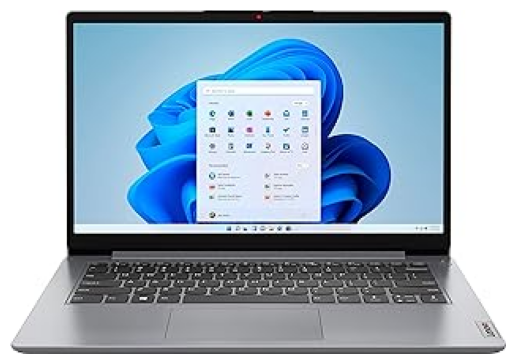

Image Index:  25
Predict:  a good product, very easy to use and easy to use.
True: bosch truemixx pro mixer grinder 1000 watt-mgm8842 min, black


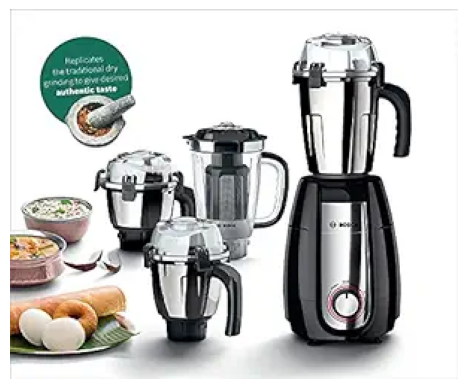

Image Index:  281
Predict:  nice touch and smell.
True: good quality item.wish it had more pocket space. but overall looks good and can withstand daily


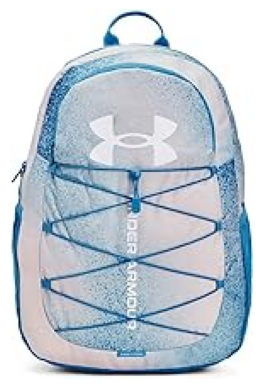

Image Index:  250
Predict:  love this little tool.
True: living up in alaska, i go through snow brushes pretty fast. they typically break just from use


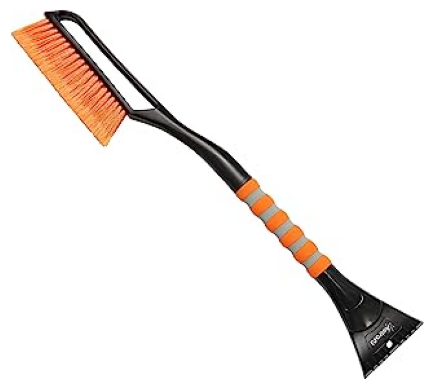

Image Index:  228
Predict:  great value for money
True: this is just what we needed in our house. all the shoes get dropped right at the door,


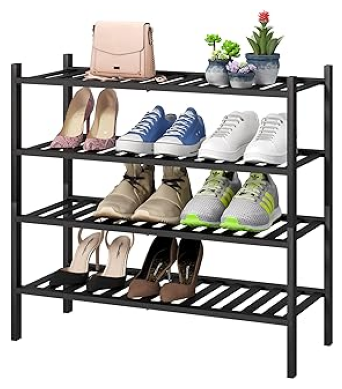

Image Index:  142
Predict:  works well.
True: eventhough smaller than what i expected,it is serving its purpose and i seem to be liking


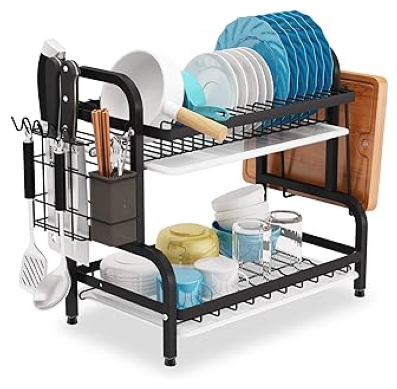

Image Index:  104
Predict:  comfortable and easy to use.
True: tv working good, the screen is va type, if we want to see good picture we need to


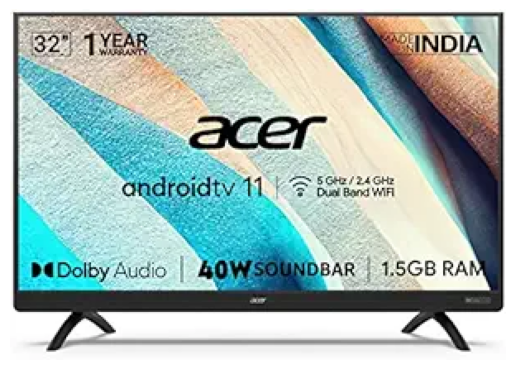

Image Index:  558
Predict:  great for everyday use
True: great, sturdy and a little goes a long way!


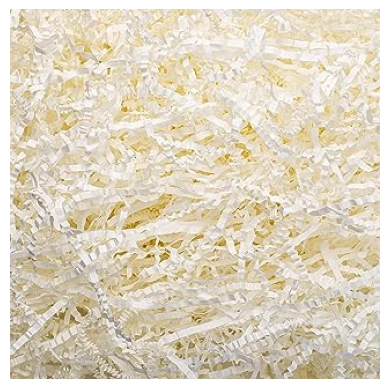

Image Index:  89
Predict:  good value for money
True: the delivery people were not careful with the unpacking. amazon needs to train their delivery staff on


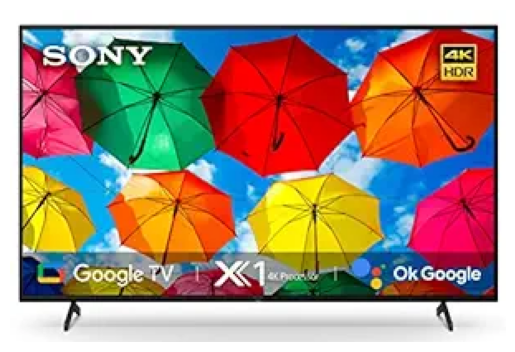

Image Index:  432
Predict:  this is a very useful tool for hunting and fishing.
True: quality products for servival purposesand camping.


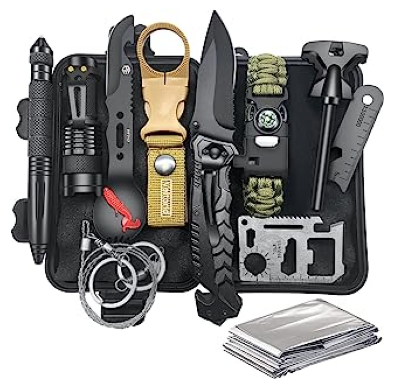

Image Index:  32
Predict:  good product,very fast charging,very fast charging.,very fast charging.,very fast charging.,very
True: worth for money - suitable for android auto... my purpose served in car....got it for rs.


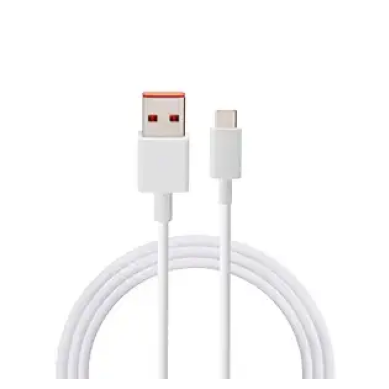

Image Index:  30
Predict:  i bought this for my daughter and she loves it.
True: this is my first 5 g iqoo mobile purchased on 26 th december at amazon.


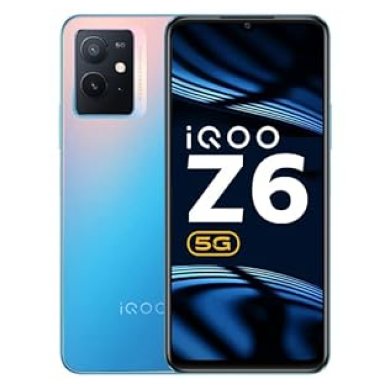

Image Index:  95
Predict:  the tv is very good.
True: about the tv - wonderful---------------------------------------------------------------probably the best tv in this price range inr13000.


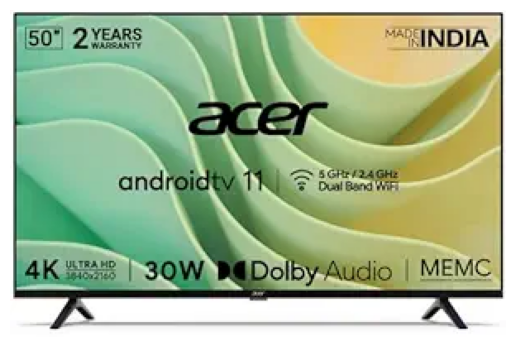

Image Index:  223
Predict:  love this patio set.
True: love this outdoor patio set. its very sturdy and the cushions are great. it was kinda hard


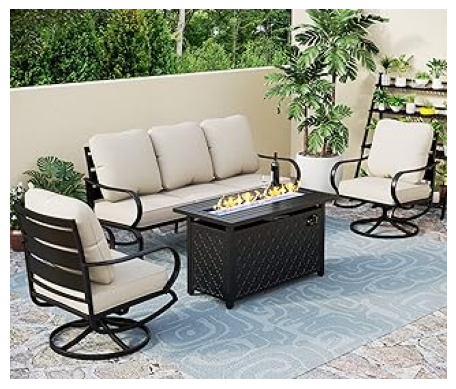

Image Index:  238
Predict:  easy to read and easy to follow.
True: this was purchased as a gift for someone with a limited recipe collection.very limited. this collection is


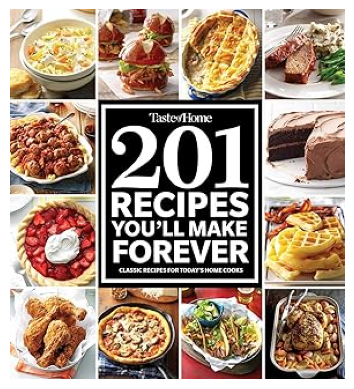

Image Index:  517
Predict:  this is a great kit
True: this is a good product to have at home


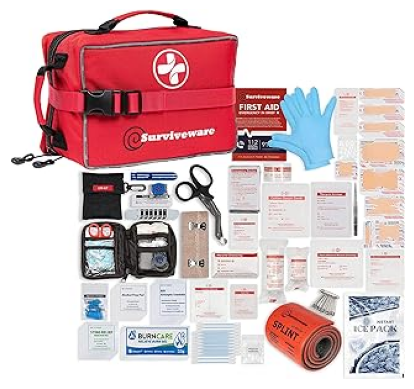

Image Index:  27
Predict:  i bought this for my wife and she loves it.
True: good product under 800 it has 3 pots for mic headphone and usb for led glow you will require a


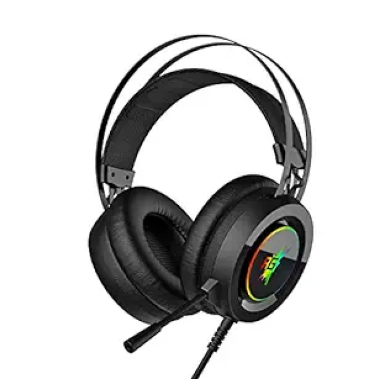

Image Index:  574
Predict:  this is a good book for anyone looking for a good book to listen to music.
True: this sent is one of the best ive had. absolutely love this candle will be getting a subscription


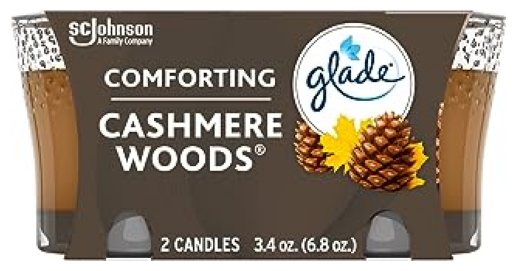

Image Index:  203
Predict:  great for appetizers! this is a great snack for appetizers. this is a great snack for
True: i had bought one of the dinosaur smasher eggs for my nephew last year at christmas. his


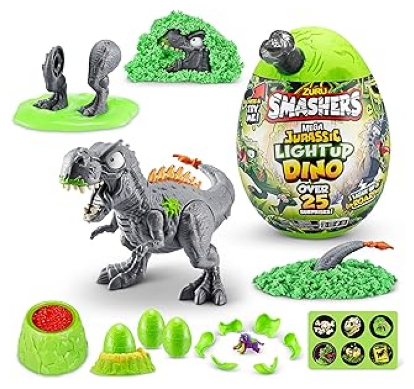

Image Index:  558
Predict:  great for everyday use
True: great, sturdy and a little goes a long way!


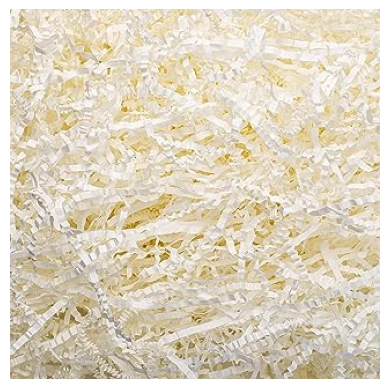

In [ ]:
import random

for i in range(20):
    rand_idx = random.randint(0, len(testset) - 1)
    img, true_text, _ = testset[rand_idx]


    img_tensor = image_processor(img, return_tensors="pt").pixel_values[0]
    text = generate_text(model, img_tensor)
    print("Image Index: ", rand_idx)
    print("Predict: ", text)
    print("True:", tokenizer.decode(true_text, skip_special_tokens=True))

    plt.imshow(img); plt.axis('off');plt.show()

In [48]:
wandb.finish()

**Cross Inference**

In [46]:
!unzip -qq Amazon.zip

Predict:  love this product


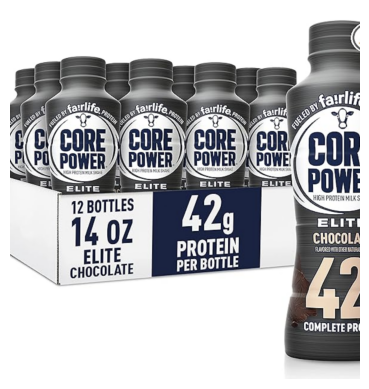

Predict:  i bought this for my daughter and she loves it.


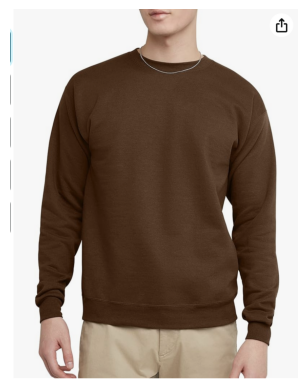

Predict:  the best product i have ever used.


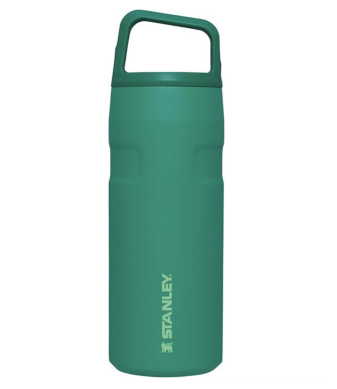

In [47]:
import os

image_dir = '/Amazon'

for filename in os.listdir(image_dir):

    if filename[-3:] in ['jpg', 'png'] or filename[-4:] in ['jpeg']:
        img = Image.open(os.path.join(image_dir, filename)).convert("RGB")


        img_tensor = image_processor(img, return_tensors="pt").pixel_values[0]
        text = generate_text(model, img_tensor)

        print("Predict: ", text)

        plt.imshow(img); plt.axis('off');plt.show()